Charles Vin (21216136) & Aymeric Delefosse (21213744) <span style="float:right">DAC 2023-2024</span><br>

# TME12 - XAI - Fairness


## Data and model fitting


In [1]:
!wget https://archive.ics.uci.edu/static/public/183/communities+and+crime.zip

--2024-01-09 18:03:42--  https://archive.ics.uci.edu/static/public/183/communities+and+crime.zip


Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘communities+and+crime.zip.3’

communities+and+cri     [       <=>          ] 264.69K   211KB/s    in 1.3s    

2024-01-09 18:03:44 (211 KB/s) - ‘communities+and+crime.zip.3’ saved [271040]



In [2]:
import zipfile
import os

# Path to the uploaded zip file
zip_file_path = "./communities+and+crime.zip"

# Directory where we'll extract the contents of the zip file
extracted_folder_path = "./communities_and_crime/"

# Create a directory for the extracted files
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the files in the extracted folder to identify the dataset file
extracted_files = os.listdir(extracted_folder_path)
extracted_files

['communities.data', 'communities.names']

In [3]:
import pandas as pd

# Path to the dataset file
dataset_file_path = os.path.join(extracted_folder_path, "communities.data")

# The dataset does not contain header information, so we might need to manually specify column names
# For now, let's load the data without column names and explore its structure
data = pd.read_csv(dataset_file_path, header=None, na_values="?")

# Re-initializing the process to extract attribute names from the .names file
# and assign them as column names to the dataset

# Path to the .names file which contains the attribute names
names_file_path = os.path.join(extracted_folder_path, "communities.names")

# Read the .names file and extract the attribute names
attribute_names = []
with open(names_file_path, "r") as file:
    for line in file:
        if line.startswith("@attribute"):
            # Extract the attribute name from the line
            attribute_name = line.split()[1]
            attribute_names.append(attribute_name)

# Assign the extracted attribute names as column names to the dataset
data.columns = attribute_names

# Display the first few rows of the dataset with the updated column names
data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Preprocessing the data
# 1. Handle missing values
# 2. Normalize numerical features

# Selecting numerical features excluding the sensitive attribute and target variable
numerical_features = data.columns.drop(
    ["communityname", "racepctblack", "ViolentCrimesPerPop"]
)

# Creating a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "imputer",
                        SimpleImputer(strategy="mean"),
                    ),  # complete missing values using mean
                    ("scaler", StandardScaler()),
                ]
            ),
            numerical_features,
        )  # standardization
    ]
)

# Preprocessed features
X = preprocessor.fit_transform(data)

# Extracting the sensitive attribute and target variable
sensitive_attr = data["racepctblack"].to_numpy()
y = data["ViolentCrimesPerPop"].to_numpy()

# Splitting the data into training and testing sets
(
    X_train,
    X_test,
    y_train,
    y_test,
    sensitive_attr_train,
    sensitive_attr_test,
) = train_test_split(X, y, sensitive_attr, test_size=0.3, random_state=42)

# Training a RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Score train :", model.score(X_train, y_train))
print("Score test :", model.score(X_test, y_test))

Score train : 0.9515854277143421
Score test : 0.6262917778910819


## Visual correlation


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


col = [
    "racepctblack",
    "racePctWhite",
    "racePctAsian",
    "racePctHisp",
    "ViolentCrimesPerPop",
]
viz_df = data[col]
viz_df["yhat"] = pd.Series(model.predict(X))

/tmp/ipykernel_32070/1282919836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_df["yhat"] = pd.Series(model.predict(X))


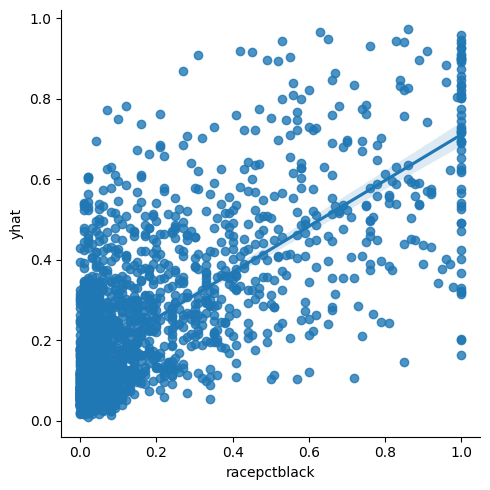

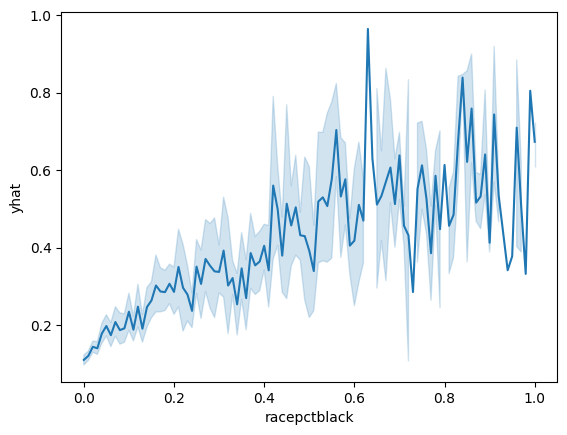

In [8]:
race = "racepctblack"
sns.lmplot(data=viz_df, x=race, y="yhat")
plt.show()
sns.lineplot(data=viz_df, x=race, y="yhat")
plt.show()

It seem that the ViolentCrimesPerPop predicted by our model is linearly correlated to the % of black people


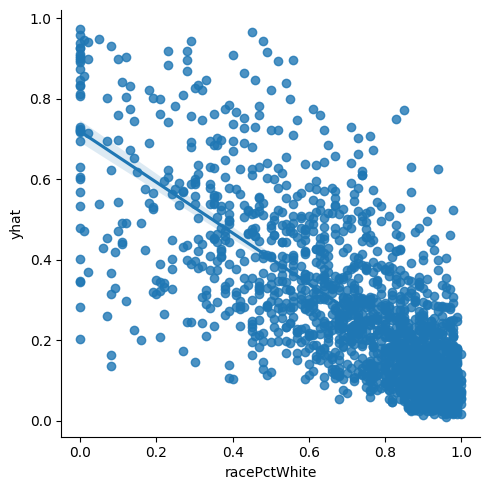

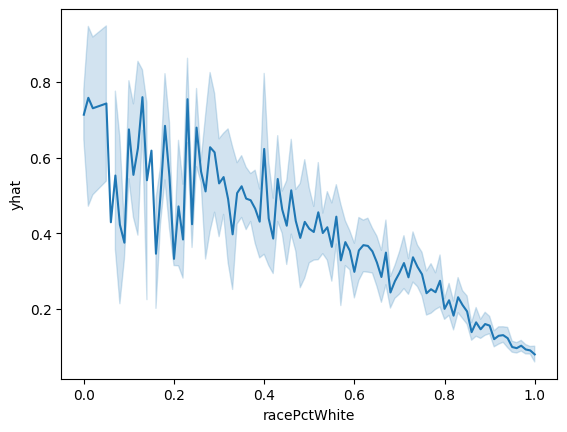

In [9]:
race = "racePctWhite"
sns.lmplot(data=viz_df, x=race, y="yhat")
plt.show()
sns.lineplot(data=viz_df, x=race, y="yhat")
plt.show()

It seem that the ViolentCrimesPerPop predicted by our model is **negativly** linearly correlated to the % of white people


## FairQuant


In [10]:
# Discretizing the sensitive attribute into quantiles
K = 5  # Number of quantiles
quantile_labels = range(K)
fairquant = {}
for race in ["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]:
    data["quantile"] = pd.qcut(data[race], q=K, labels=quantile_labels)

    # Calculate mean predictions for each quantile
    quantile_means = []
    for k in quantile_labels:
        idx = data["quantile"] == k
        X_quantile = preprocessor.transform(data[idx])
        y_pred_quantile = model.predict(X_quantile)
        quantile_means.append(np.mean(y_pred_quantile))

    # Calculate the overall mean prediction
    overall_mean = np.mean(model.predict(X))

    # Compute the FairQuant metric
    fairquant[race] = sum(abs(mk - overall_mean) for mk in quantile_means) / K
fairquant

{'racepctblack': 0.11068777831261283,
 'racePctWhite': 0.13018040446171106,
 'racePctAsian': 0.012738030128497873,
 'racePctHisp': 0.05541688106038478}

La FairQuant plus élevée pour les populations blanches et afro-américaines, suggérant un biais dans notre modèle.


## Linear correlation

Let's see the Pearson $r$ coef to measure linear correlation


In [11]:
import scipy.stats as stats

# Calculer le coefficient de corrélation dePearson entre la race et la variable 'ViolentCrimesPerPop'
corr = {}
yhat = model.predict(X)
for race in ["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]:
    pearson_corr, p_value = stats.pearsonr(data[race], yhat)
    corr[race] = pearson_corr
corr

{'racepctblack': 0.7142010444512937,
 'racePctWhite': -0.7614886054367039,
 'racePctAsian': 0.02649578062859266,
 'racePctHisp': 0.31192767981560177}

Le modèle est biaisé pour les populations afro-américaines et les populations blanches : il est très peu probable qu'une personne blanche prédise un crime et c'est l'inverse pour une personne noire. Le modèle n'est pas biaisé pour les personnes asiatiques, et légérément pour les personnes hispaniques.

On peut comparer ces corrélations aux corrélation "réelles" :


In [12]:
# Calculate the Pearson correlation coefficient between race and the target variable 'ViolentCrimesPerPop'
corr = {}
yhat = model.predict(X)
for race in ["racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]:
    pearson_corr, p_value = stats.pearsonr(data[race], data["ViolentCrimesPerPop"])
    corr[race] = pearson_corr
corr

{'racepctblack': 0.6312636346597025,
 'racePctWhite': -0.6847695762715431,
 'racePctAsian': 0.03762178678135556,
 'racePctHisp': 0.2930502181250693}

## HGR


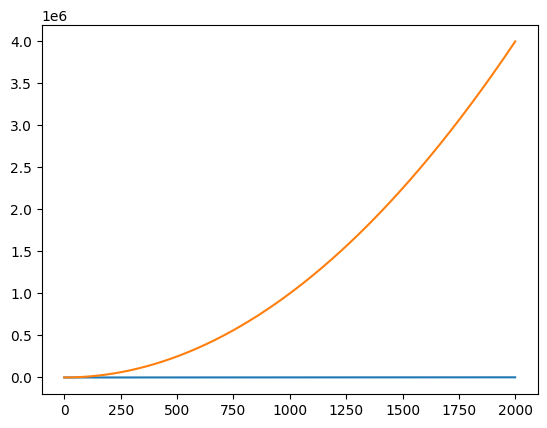

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the neural network for transforming Y and S
class TransformNet(nn.Module):
    def __init__(self, dim):
        super(TransformNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim // 2), nn.ReLU(), nn.Linear(dim // 2, dim)
        )

    def forward(self, x):
        return self.net(x)


n = 2000
S = torch.linspace(0, n, n)
Y = S**2

plt.plot(S)
plt.plot(Y)

In [16]:
# Initialize the networks for Y and S
net_Y = TransformNet(n)
net_S = TransformNet(n)

# Loss function and optimizer
optimizer_Y = optim.Adam(net_Y.parameters(), lr=0.001)
optimizer_S = optim.Adam(net_S.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer_Y.zero_grad()
    optimizer_S.zero_grad()

    transformed_Y = net_Y(Y)
    transformed_S = net_S(S)

    # Standardize the outputs
    transformed_Y = (transformed_Y - transformed_Y.mean()) / transformed_Y.std()
    transformed_S = (transformed_S - transformed_S.mean()) / transformed_S.std()

    # Loss is negative correlation
    loss = -torch.mean(transformed_Y * transformed_S)

    loss.backward()
    optimizer_Y.step()
    optimizer_S.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: -0.0254
Epoch [11/100], Loss: -0.9750
Epoch [21/100], Loss: -0.9947
Epoch [31/100], Loss: -0.9977
Epoch [41/100], Loss: -0.9989
Epoch [51/100], Loss: -0.9993
Epoch [61/100], Loss: -0.9994
Epoch [71/100], Loss: -0.9995
Epoch [81/100], Loss: -0.9995
Epoch [91/100], Loss: -0.9995
